# Notebook Assignement 1

Import delle librerie

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Strumenti di classificazione
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Feature audio avanzate
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

In questo esercizio andremo a classificare gli audio in base alle feature che andremo ad estrarre da essi.

Per prima cosa gli audio vengono estratti dalla repository, dopo averli rimescolati tra di loro gli viene assegnata una categoria di appartenenza e successivamente viene creato il training e test set per la classificazione e i segnali vengono normalizzati.

In [2]:
def identity(input):
    return input

def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# Creazione delle Feature

Passiamo quindi alla fase di creazione delle feature che andremo ad estrarre dai nostri audio; queste feature saranno i descrittori che useremo per addestrare il nostro modello alla classificazione degli audio.

Le feature che andiamo ad estrarre saranno:

- crop: feature che va ad eliminare quelli che sono i valori presi dal segnale che superano un certo limite imposto (o ne aggiungono per arrivare a quel valore).
- sdev: è la deviazione standard dei valori che vengono presi dal segnale monodimensionale.
- avg: è il valore medio dei valori che compongono il nostro segnale monodimensionale.
- aavg: è la media assoluta, cioè la media dei valori che compongono il segnale presi con il modulo.
- duration: è la durata del nostro segnale monodimensionale.
- energy: rappresenta l'energia del nostro segnale, calcolata come la somma dei valori che lo compongono elevati alla seconda.
- mfcc: Mel-frequency cepstral coefficients sono dei coefficenti che vengono calcolati in maniera automatica.

In [6]:
def crop(input, size=100):
    # Elimina eventuali valori oltre il numero consentito
    output = input[0:min(size, input.shape[0])]
    # Aggiungi valori nulli per raggiungere la dimensione richiesta
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

def sdev(input):
    return np.std(input, keepdims=True)

def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

def duration(input):
    return input.shape

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def mfcc(input, rate=8000, min_len=40, sampling=1):
    # Campiona i valori
    signal = input[::sampling]
    # Calcola coefficienti MFCC
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    # Applica eventuali zeri aggiuntivi per raggiungere una lunghezza fissa
    pad_width = min_len - mfcc.shape[1]
    print(mfcc.shape[1])
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Appiattisci rappresentazione per uso con SVM
    mfcc = mfcc.flatten()
    return mfcc

**Creazione ZCR**

Creiamo la nostra feature ZCR, che va a contare ogni volta che il segnale cambia il suo segno.

Viene fatta un'analisi su un singolo vettore che rappresenta il segnale. La funzione valuta il valore del segnale in ogni punto; quindi se il valore è = 0, allora viene contato uno zero, altrimenti, se il segnale ha prima un valore maggiore (o minore) di zero, e poi il suo valore diventa minore (o maggiore) di zero, allora conta uno zero. Viene svolto in questa maniera perché non è detto che il segnale, anche se cambia segno, abbia un valore = 0.

In [5]:
def zcr(input):
    sign = input
    zeri = 0
    for i in range(0,len(sign)-1):
        if sign[i] == 0:
            zeri +=1
        else:
            if sign[i+1] >0:
                if sign[i]<0:
                    zeri +=1
            else:
                if sign[i+1]<0:
                    if sign[i]>0:
                        zeri +=1
    return [zeri]

Ne proviamo l'efficacia su un vettore di test; dovrebbe venire come risultato 5.

In [6]:
vettore = [5,-3,1,9,-6,-7,2,1,10,-5]
test = np.array(vettore)
print(zcr(test))

[5]


# Definiamo le combo di feature

A questo punto andiamo a definire le combo di feature che utilizzeremo poi. Ne vengono definite 3 e le corrispettive contenenti anche la feature zcr, per testarne l'efficacia nel migliorarne le performance

In [23]:
def combo1(input):
    return np.concatenate((duration(input),energy(input)))

def combo2(input):
    return np.concatenate((zcr(input),duration(input),energy(input)))

def combo3(input):
    return np.concatenate((sdev(input),avg(input),aavg(input),energy(input)))

def combo4(input):
    return np.concatenate((zcr(input),sdev(input),avg(input),aavg(input),energy(input)))

def combo5(input):
    return np.concatenate((avg(input),duration(input),energy(input),crop(input),aavg(input),sdev(input)))

def combo6(input):
    return np.concatenate((zcr(input),avg(input),duration(input),energy(input),crop(input),aavg(input),sdev(input)))

**COMBO 1**

Cominciamo con il caricamento dei nostri dati e insieme andiamo a normalizzarli, basandoci sul training set; utilizziamo una feature extraction per trovare i parametri migliori. In questo primo caso utiliziamo le feature di durata e energia.

Utilizzeremo la prima combo composta da *durata* e *energia* per allenare il nostro modello e vediamo come performa

In [7]:
x_train, x_test, y_train, y_test = load_data(normalize = True, feature_extractor=mfcc)

11
9
11
10
8
10
10
10
9
9
11
10
9
10
10
10
10
11
10
10
11
11
10
10
11
9
10
11
11
10
10
10
11
10
9
12
11
11
10
11
11
11
11
11
13
9
10
9
10
10
7
8
8
9
9
8
8
9
8
8
9
8
6
8
8
7
8
7
7
7
8
8
7
9
8
6
6
6
6
6
6
6
6
7
8
8
8
8
8
7
8
8
8
7
7
7
9
7
8
8
7
6
6
6
8
7
6
7
7
6
7
8
6
7
6
9
7
7
8
8
9
10
8
6
9
8
5
11
9
9
8
7
9
7
7
7
8
8
7
8
7
7
7
6
6
7
7
7
6
7
9
9
10
8
8
8
11
8
8
7
8
8
8
8
8
7
8
8
9
9
8
8
8
8
8
9
9
10
8
8
7
7
8
9
9
10
10
10
9
10
10
9
9
10
8
9
8
9
8
10
6
5
6
6
6
5
6
5
5
4
5
4
5
5
5
6
5
5
6
6
4
6
5
5
5
5
6
7
5
5
6
6
5
6
5
6
5
5
5
6
5
5
4
6
5
6
5
5
4
5
4
4
5
4
4
6
4
4
4
5
4
6
4
6
8
9
8
5
5
5
8
9
8
4
7
12
8
8
5
6
5
5
5
5
4
5
4
7
7
5
4
5
5
6
5
4
4
5
5
4
8
9
9
9
8
9
9
9
8
9
9
9
7
8
12
8
8
9
9
8
9
8
9
8
8
8
8
8
8
8
8
7
8
8
8
9
10
10
9
10
11
9
8
8
9
8
8
8
8
9
6
5
5
6
5
5
6
6
6
5
7
4
6
5
3
6
3
4
6
5
4
6
5
4
5
4
4
4
5
6
6
4
6
4
6
6
6
5
6
5
5
5
7
7
6
3
4
5
4
6
4
4
4
4
5
5
5
5
8
6
4
8
9
6
7
6
8
11
11
10
7
7
7
4
5
6
5
5
3
5
5
5
6
5
5
4
5
5
4
4
5
5
4
4
4
5
4
4
5
4
8
8
8
7
8
7
8
8
8
8
8
7
8
8
8
7
8
7
8


In [5]:
x_test

[array([ 1.00348664e-01, -1.67073202e-01, -1.87056529e-01,  2.29133222e-01,
         4.40026551e-01,  6.34565447e-01,  9.63813776e-01,  1.48416739e+00,
        -4.76108118e-01, -3.48268989e-01, -2.40949289e-01, -1.62127585e-01,
        -1.27664015e-01, -8.52384336e-02, -5.37036713e-02, -5.40306795e-02,
        -5.42730460e-02, -3.84549821e-02, -3.84551739e-02, -3.84547422e-02,
        -3.84539512e-02, -3.84548316e-02, -3.84549331e-02, -3.84550742e-02,
        -3.84548753e-02, -3.84544197e-02, -3.84546932e-02, -3.84549239e-02,
        -3.84551526e-02, -3.84548469e-02, -3.84503182e-02, -3.84507107e-02,
        -3.84553946e-02, -3.82585473e-02, -3.80007757e-02, -2.71474130e-02,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        -4.79613732e-01, -7.02802674e-01, -6.57003786e-01,  2.16675774e-01,
         4.16208168e-01,  2.32947913e-01,  2.65527268e-01,  3.61033961e-01,
        -3.87047172e-01, -2.84210785e-01, -1.90591232e-01, -1.41740836e-01,
        -1.1

Creiamo un dizioniario di parametri che passati alla nostra SVM possono essere usati per tunare i parametri e migliorare il modello. In questo modo istanzio i parametri, e gli dico quali valori possono essere presi

In [25]:
param_grid = {'C': [100,500,1000], 'gamma':[0.005,0.01,0.1,0.5,1.0]}

Creiamo quindi il nostro modello di classificazione per il riconoscimento della voce, utilizzando una SVM; andiamo a fare quindi una Grid Search per trovare quelli che sono i parametri migliori per il nostro classificatore.

- La support vector machine avrà come kernel un 'rbf' e il parametro class_weight viene usato per pesare i valori delle classi in maniera inversamente proporzionale alla loro frequenza nel dataset di input.
- Il parametro param_grid è il dizionario di parametri in input che verranno poi provati per trovare quelli migliori per C e gamma.
- Il parametro cv sta ad indicare che facciamo una cross validation del nostro training set, dividendolo in 2.

In [26]:
clf = GridSearchCV(SVC(kernel = 'rbf', class_weight='balanced'), param_grid, cv = 2)

Addestriamo la nostra SVM 

In [27]:
clf = clf.fit(x_train, y_train)

Facciamo la previsione e vediamo quindi i risultati ottenuti

In [11]:
y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.33      0.24      0.28        17
           1       0.25      0.30      0.27        10
           2       0.25      0.13      0.17        15
           3       0.45      0.68      0.54        19
           4       0.50      0.36      0.42        11
           5       0.27      0.21      0.24        14
           6       0.33      0.43      0.38        14
           7       0.17      0.11      0.13        19
           8       0.20      0.24      0.22        17
           9       0.40      0.57      0.47        14

    accuracy                           0.33       150
   macro avg       0.32      0.33      0.31       150
weighted avg       0.31      0.33      0.31       150



Andiamo anche a mostrare quella che è la matrice di confusione del nostro classificatore; al di sopra una rappresentazione numerica, mentre al di sotto una rappresentazione heat-map.

[[ 4  0  0  0  0  0  4  2  2  5]
 [ 0  3  0  4  0  0  0  1  2  0]
 [ 1  1  2  3  0  1  1  3  1  2]
 [ 0  1  2 13  0  0  0  2  0  1]
 [ 0  2  1  1  4  2  0  0  1  0]
 [ 1  1  1  0  1  3  1  1  4  1]
 [ 3  0  1  2  0  0  6  0  2  0]
 [ 2  2  1  3  0  2  2  2  3  2]
 [ 0  0  0  3  3  3  2  1  4  1]
 [ 1  2  0  0  0  0  2  0  1  8]]


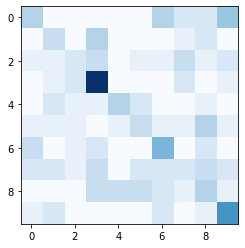

In [12]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

**COMBO 2**

Rieseguiamo i passi svolti in precedenza e vediamo se la combo di feature che comprende oltre alle feature precedenti anche la *zcr* performa meglio rispetto a quella precedente. 

In [13]:
x_train, x_test, y_train, y_test = load_data(normalize = True, feature_extractor=combo2)

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight='balanced'), param_grid, cv = 2)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        17
           1       0.33      0.80      0.47        10
           2       0.50      0.40      0.44        15
           3       0.56      0.26      0.36        19
           4       0.33      0.45      0.38        11
           5       0.35      0.50      0.41        14
           6       0.79      0.79      0.79        14
           7       0.38      0.16      0.22        19
           8       0.44      0.41      0.42        17
           9       0.47      0.64      0.55        14

    accuracy                           0.47       150
   macro avg       0.49      0.50      0.47       150
weighted avg       0.50      0.47      0.46       150



[[10  0  0  0  0  1  0  0  1  5]
 [ 0  8  0  0  2  0  0  0  0  0]
 [ 0  1  6  1  0  1  1  1  1  3]
 [ 0  8  3  5  0  0  1  1  1  0]
 [ 1  2  0  0  5  0  0  1  2  0]
 [ 0  1  0  0  4  7  0  2  0  0]
 [ 0  0  0  1  0  0 11  0  2  0]
 [ 1  1  3  1  1  6  0  3  2  1]
 [ 0  2  0  1  1  4  1  0  7  1]
 [ 1  1  0  0  2  1  0  0  0  9]]


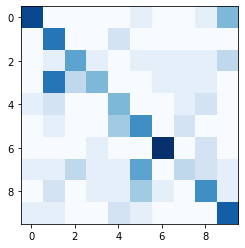

In [14]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Vediamo che abbiamo un aumento delle performance con l'aggiunta della nuova feature; in generale l'accuracy passa da 0.33 a 0.47.

**COMBO 3**

Proviamo quindi con un'altra combo di feature, composta *deviazione standard*, *media*, *media assoluta* e *energia*.

In [15]:
x_train, x_test, y_train, y_test = load_data(normalize = True, feature_extractor=combo3)

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight='balanced'), param_grid, cv = 2)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80        17
           1       0.43      0.60      0.50        10
           2       0.30      0.40      0.34        15
           3       0.54      0.37      0.44        19
           4       0.22      0.36      0.28        11
           5       0.38      0.36      0.37        14
           6       0.80      0.86      0.83        14
           7       0.73      0.42      0.53        19
           8       0.44      0.47      0.46        17
           9       0.80      0.57      0.67        14

    accuracy                           0.52       150
   macro avg       0.54      0.52      0.52       150
weighted avg       0.56      0.52      0.53       150



[[14  0  0  0  3  0  0  0  0  0]
 [ 0  6  1  1  1  0  1  0  0  0]
 [ 2  1  6  2  0  0  0  1  1  2]
 [ 1  3  6  7  1  1  0  0  0  0]
 [ 0  2  3  0  4  2  0  0  0  0]
 [ 0  0  0  1  4  5  0  2  2  0]
 [ 0  0  0  0  0  0 12  0  2  0]
 [ 0  1  1  0  1  3  2  8  3  0]
 [ 0  0  2  2  3  2  0  0  8  0]
 [ 1  1  1  0  1  0  0  0  2  8]]


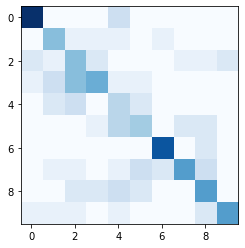

In [16]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Vediamo che questa nuova combo di feature performa meglio rispetto a quella prima, anche senza la presenza della zcr. 

**COMBO 4**

Proviamo ad aggiungere la feature zcr alla combo appena usata e vediamo come performa.

In [17]:
x_train, x_test, y_train, y_test = load_data(normalize = True, feature_extractor=combo4)

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight='balanced'), param_grid, cv = 2)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80        17
           1       0.62      0.80      0.70        10
           2       0.65      0.73      0.69        15
           3       0.60      0.63      0.62        19
           4       0.80      0.73      0.76        11
           5       0.55      0.43      0.48        14
           6       0.75      0.86      0.80        14
           7       0.80      0.42      0.55        19
           8       0.61      0.65      0.63        17
           9       0.59      0.93      0.72        14

    accuracy                           0.67       150
   macro avg       0.69      0.69      0.67       150
weighted avg       0.69      0.67      0.67       150



[[12  0  0  1  0  0  0  0  0  4]
 [ 0  8  0  1  0  0  0  0  0  1]
 [ 0  0 11  3  0  0  0  0  1  0]
 [ 0  2  3 12  0  1  0  0  0  1]
 [ 1  1  0  0  8  1  0  0  0  0]
 [ 0  0  1  0  1  6  2  1  1  2]
 [ 0  0  0  0  0  0 12  1  1  0]
 [ 0  1  1  0  0  2  2  8  4  1]
 [ 0  0  1  3  1  1  0  0 11  0]
 [ 0  1  0  0  0  0  0  0  0 13]]


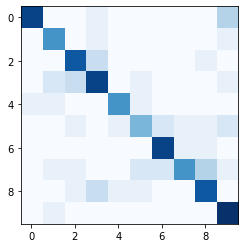

In [18]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Otteniamo anche qui un incremento rispetto ai risultati ottenuti con le feature precendenti; aumentano anche le metriche medie degli altri indicatori oltre che l'accuracy e quest'ultima passa da 0.52 a 0.67.

**COMBO 5**

Proviamo a questo punto ad usare la combo composta da *media*, *durata*. *energia*, *crop*, *media assoluta* e *deviazione standard* e a vedere come performa il modello.

In [19]:
x_train, x_test, y_train, y_test = load_data(normalize = True, feature_extractor=combo5)

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight='balanced'), param_grid, cv = 2)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

C:\Users\dexte\.conda\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


              precision    recall  f1-score   support

           0       0.63      0.71      0.67        17
           1       0.47      0.70      0.56        10
           2       0.20      0.60      0.30        15
           3       0.44      0.21      0.29        19
           4       0.25      0.27      0.26        11
           5       0.25      0.07      0.11        14
           6       0.61      0.79      0.69        14
           7       0.29      0.26      0.28        19
           8       0.20      0.06      0.09        17
           9       0.60      0.21      0.32        14

    accuracy                           0.37       150
   macro avg       0.39      0.39      0.36       150
weighted avg       0.39      0.37      0.35       150



[[12  2  1  0  1  0  0  0  0  1]
 [ 0  7  1  0  0  0  0  2  0  0]
 [ 1  1  9  1  0  1  1  1  0  0]
 [ 0  0  9  4  4  0  1  1  0  0]
 [ 0  0  6  1  3  0  0  0  1  0]
 [ 1  1  2  3  0  1  1  2  2  1]
 [ 0  0  1  0  1  0 11  1  0  0]
 [ 2  1  2  0  3  1  4  5  1  0]
 [ 0  2 12  0  0  0  0  2  1  0]
 [ 3  1  3  0  0  1  0  3  0  3]]


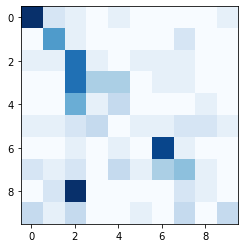

In [20]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Con questa ultima combo assistiamo ad una diminuzione delle performance del nostro modello, che passano da un'accuracy di 0.67 della combo precedente a 0.37 con la combo corrente.

**COMBO 6**

Proviamo a questo punto ad inserire anche la zcr oltre alle feature già presenti e a vedere se assistiamo ad un miglioramento delle performance.

In [21]:
x_train, x_test, y_train, y_test = load_data(normalize = True, feature_extractor=combo6)

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight='balanced'), param_grid, cv = 2)
clf = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.65      0.63        17
           1       0.47      0.90      0.62        10
           2       0.38      0.60      0.46        15
           3       0.58      0.37      0.45        19
           4       0.18      0.18      0.18        11
           5       0.27      0.29      0.28        14
           6       0.74      1.00      0.85        14
           7       0.53      0.42      0.47        19
           8       0.60      0.18      0.27        17
           9       0.58      0.50      0.54        14

    accuracy                           0.49       150
   macro avg       0.49      0.51      0.48       150
weighted avg       0.51      0.49      0.48       150



[[11  1  0  0  1  0  0  0  1  3]
 [ 0  9  0  0  1  0  0  0  0  0]
 [ 0  1  9  0  0  1  2  1  1  0]
 [ 1  1  2  7  3  3  0  2  0  0]
 [ 0  1  5  2  2  1  0  0  0  0]
 [ 0  0  1  1  3  4  2  2  0  1]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  2  1  2  1  3  1  8  0  1]
 [ 1  3  6  0  0  2  0  2  3  0]
 [ 5  1  0  0  0  1  0  0  0  7]]


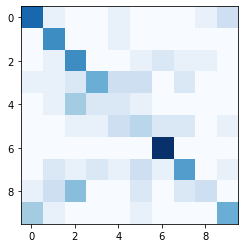

In [22]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Vediamo che inserendo la zcr assistiamo ad un aumento delle performance del nostro modello, in particolare l'accuracy, che passa da 0.37 a 0.49. Questo indica che la feature zcr risulta essere un ottimo indicatore per classificare gli audio.

Vediamo a questo punto gli iperparametri che sono stati scelti

In [23]:
print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

Migliore combinazione di parametri:
 C: 100
 gamma: 0.01
